In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig
from sae.SAE_methods import AutoEncoder #import sparse autoencoder from local definition

#load ESM2 model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = model.to("cuda")

#load SAE (GPU-only)
sparse_autoencoder = AutoEncoder.from_pretrained("evillegasgarcia/sae_esm2_6_l3")

Loss not defined in config, using default l1 loss


In [4]:
config = AutoConfig.from_pretrained("facebook/esm2_t6_8M_UR50D")
config

/u/area/evillegas/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


EsmConfig {
  "_name_or_path": "facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}

In [ ]:
#setup to extract ESM2 embeddings
layer_name = "esm.encoder.layer.3.output"
#define hook
intermediate_embs = dict()
def hook(module, input, output):
    intermediate_embs[layer_name] = output
return hook
#attach hook
hook_handle = model.esm.encoder.layer[3].output.register_forward_hook(l3_hook)

In [51]:
#Inference
sequence = "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPL"

#PLM Inference
tokenized = tokenizer.encode(sequence, return_tensors="pt")
tokenized = tokenized.to("cuda")
outputs = model(tokenized)
embeddings = intermediate_embs[layer_name][0]

#SAE Inference
_, _, sae_embeddings, _, _ = sparse_autoencoder(embeddings)

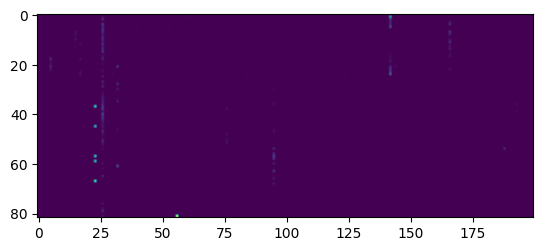

In [52]:
import matplotlib.pyplot as plt
plt.imshow(mid_acts.detach().cpu().numpy()[0:200,0:200])

In [ ]:
hook_handle.remove()